# Tunability analysis and additional visualizations

This notebook loads the project's `tunability_analysis.csv` files (one per `results/usage_*` folder) and produces a set of visualizations useful for the hyperparameter tunability project. The notebook focuses on the tunability metric (difference in risk/performance after tuning), but also shows aggregated performance and relationships between reference performance and tunability.

Planned visualizations:
- Boxplot / violin: distribution of `tunability_risk_diff` by sampling method (grid/random/bayesian).
- Heatmap: average tunability per model × dataset-usage-percent.
- Per-model violin/boxplots split by sampling method.
- Scatter: reference AUC vs tunability, to see whether high-performing datasets are more/less tunable.
- (Optional) save aggregated CSV and figure files into `results/analysis/` for record keeping.

In [7]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from glob import glob

# plotting style
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 120

In [8]:
import pathlib
print(pathlib.Path('.').resolve())

C:\Users\jdudz\Documents\hyperparameter-tunability-project\analysis


In [9]:
# Find all tunability CSVs under results/usage_*
base = pathlib.Path('../') / 'results'
csv_paths = sorted(glob(str(base / 'usage_*' / 'tunability_analysis.csv')))
print(f'Found {len(csv_paths)} tunability CSV files')

# Load and concatenate, adding a dataset_usage_percent column from the parent folder name
frames = []
for p in csv_paths:
    df = pd.read_csv(p)
    # attempt to parse usage percent from the path like results/usage_10/
    usage_str = pathlib.Path(p).parents[0].name  # e.g. 'usage_10'
    try:
        usage = int(usage_str.split('_')[-1])
    except Exception:
        usage = None
    df['dataset_usage_percent'] = usage
    frames.append(df)

if len(frames) == 0:
    print('No tunability CSV files found. Check results/usage_*/tunability_analysis.csv')
else:
    tun_df = pd.concat(frames, ignore_index=True)
    print('Concatenated shape:', tun_df.shape)
    display(tun_df.head())

Found 5 tunability CSV files
Concatenated shape: (75, 10)


,model,sampling_method,dataset_id,dataset_usage_percent,reference_auc,reference_risk,best_dataset_auc,best_dataset_risk,tunability_risk_diff,n_trials
0,xgboost,bayesian,1590,100,0.928463,0.071537,0.929111,0.070889,0.000649,32
1,xgboost,bayesian,1510,100,0.993160,0.006840,0.993880,0.006120,0.000721,32
2,xgboost,bayesian,1461,100,0.551863,0.448137,0.551863,0.448137,0.000000,32
3,xgboost,bayesian,24,100,0.965556,0.034444,0.977348,0.022652,0.011792,32
4,xgboost,bayesian,40945,100,0.969957,0.030043,0.971559,0.028441,0.001602,32


## 1) Distribution of tunability by sampling method

A quick way to understand how much tuning matters depending on the sampler (grid/random/bayesian). We plot `tunability_risk_diff` (lower is less tunable — risk decreased after tuning).

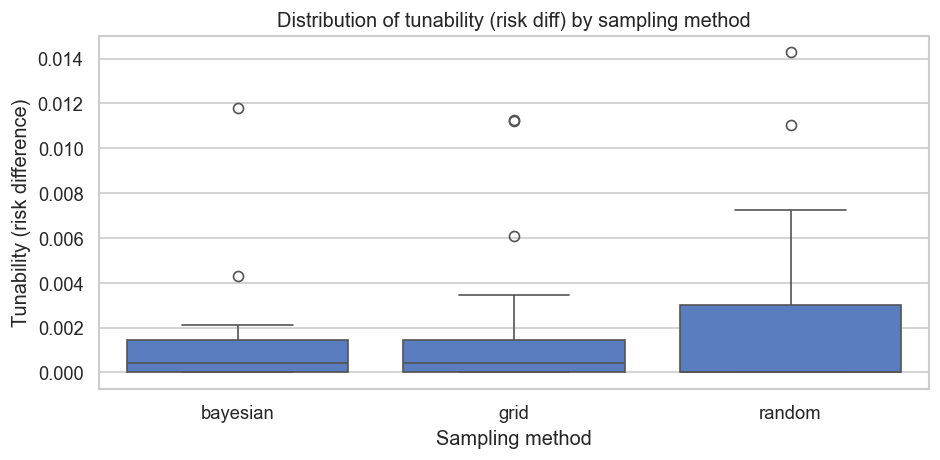

In [16]:
# Boxplot / violinplot of tunability_risk_diff by sampling_method
fig, ax = plt.subplots(figsize=(8, 4))
if 'tunability_risk_diff' in tun_df.columns:
    sns.boxplot(
        data=tun_df, x='sampling_method', y='tunability_risk_diff', ax=ax,
        order=sorted(tun_df['sampling_method'].unique())
    )
    ax.set_title('Distribution of tunability (risk diff) by sampling method')
    ax.set_ylabel('Tunability (risk difference)')
    ax.set_xlabel('Sampling method')
    plt.tight_layout()
    plt.show()
else:
    print('Column tunability_risk_diff not found in the loaded data')

## 2) Heatmap: average tunability by model and dataset usage percent

This shows how tunability changes when you vary the fraction of each dataset used (10/25/50/75/100).

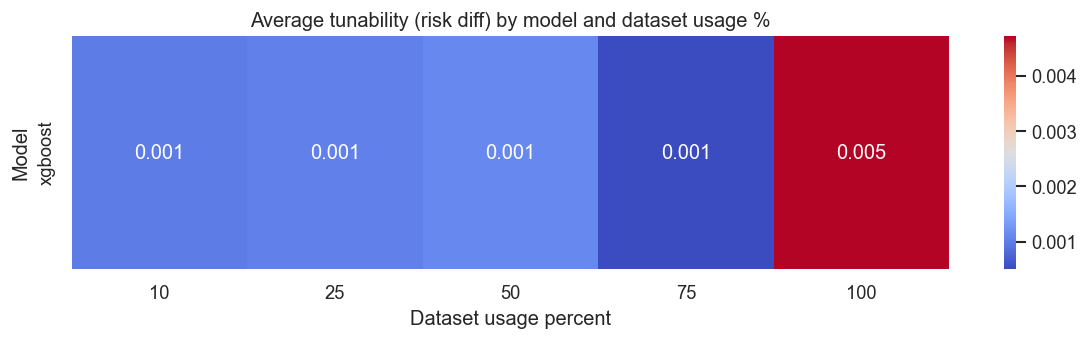

In [11]:
# Pivot table: average tunability per model × dataset_usage_percent
pivot = (
    tun_df.groupby(['model', 'dataset_usage_percent'])['tunability_risk_diff']
    .mean()
    .unstack(level=-1)
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(10, max(3, 0.5 * len(pivot))))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='coolwarm', ax=ax)
ax.set_title('Average tunability (risk diff) by model and dataset usage %')
ax.set_xlabel('Dataset usage percent')
ax.set_ylabel('Model')
plt.tight_layout()
plt.show()

In [ ]:
# Aggregated tunability per algorithm (model) across datasets and usage percentages
if 'tunability_risk_diff' in tun_df.columns and not tun_df.empty:
    # mean, std and count per algorithm
    algo_stats = tun_df.groupby('model')['tunability_risk_diff'].agg(['mean', 'std', 'count']).reset_index()
    algo_stats = algo_stats.sort_values('mean', ascending=False)
    display(algo_stats)

    # bar plot with error bars (std)
    models = algo_stats['model'].astype(str).tolist()
    means = algo_stats['mean'].values
    stds = algo_stats['std'].fillna(0).values
    x = np.arange(len(models))
    fig, ax = plt.subplots(figsize=(10, 4))
    colors = sns.color_palette('muted', n_colors=len(models))
    ax.bar(x, means, yerr=stds, capsize=5, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('Mean tunability (risk diff)')
    ax.set_title('Mean tunability per algorithm (across datasets and usages)')
    plt.tight_layout()
    plt.show()

    # breakdown by sampling method
    breakdown = tun_df.groupby(['model', 'sampling_method'])['tunability_risk_diff'].mean().unstack().fillna(0)
    display(breakdown)
    fig, ax = plt.subplots(figsize=(10, max(3, 0.4 * len(breakdown))))
    breakdown.plot(kind='bar', ax=ax)
    ax.set_ylabel('Mean tunability (risk diff)')
    ax.set_title('Tunability per algorithm split by sampling method')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # save per-algorithm summary
    out_dir = pathlib.Path('results') / 'analysis'
    out_dir.mkdir(parents=True, exist_ok=True)
    algo_stats.to_csv(out_dir / 'tunability_per_algorithm.csv', index=False)
    print('Wrote per-algorithm summary to', out_dir / 'tunability_per_algorithm.csv')
else:
    print('No tunability data available to compute per-algorithm summaries')

## 3) Per-model distributions (tunability by sampling method)

Look at each model separately to see whether certain samplers consistently give higher tunability gains for that model.

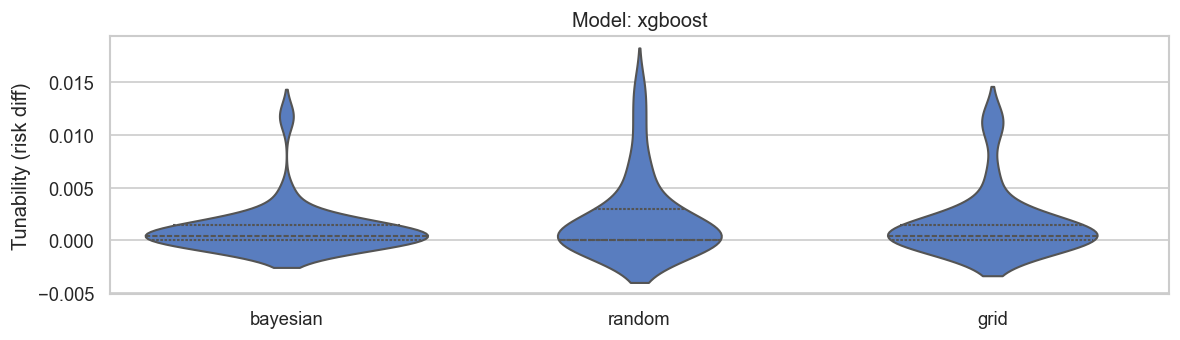

In [12]:
models = tun_df['model'].unique()
n = len(models)
fig, axes = plt.subplots(max(1, n), 1, figsize=(10, 3 * n), squeeze=False)
for i, model in enumerate(sorted(models)):
    ax = axes[i, 0]
    subset = tun_df[tun_df['model'] == model]
    if subset.empty:
        continue
    sns.violinplot(
        data=subset, x='sampling_method', y='tunability_risk_diff', ax=ax, inner='quartile'
    )
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('')
    ax.set_ylabel('Tunability (risk diff)')
plt.tight_layout()
plt.show()

## 4) Relationship: reference performance vs tunability

Plot reference AUC (or other performance) against tunability to check whether well-performing datasets are less tunable.

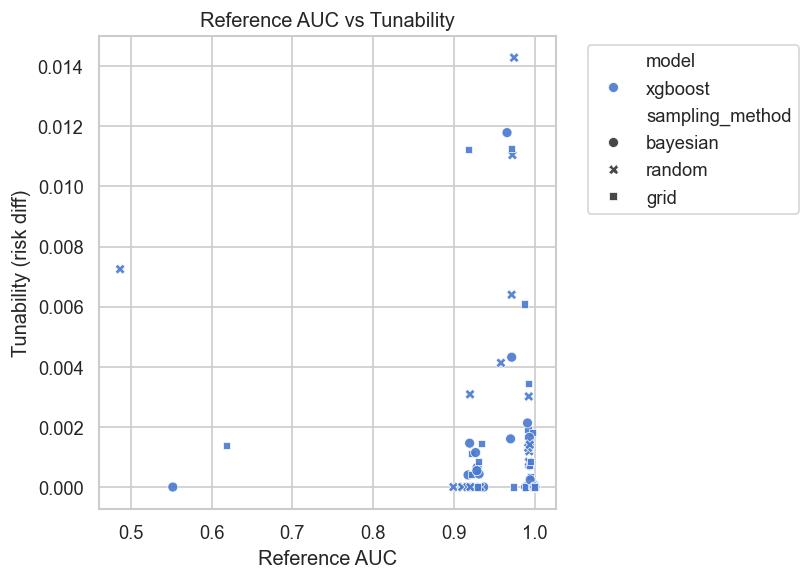

In [13]:
if 'reference_auc' in tun_df.columns:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(
        data=tun_df, x='reference_auc', y='tunability_risk_diff', hue='model', style='sampling_method', ax=ax,
        alpha=0.9
    )
    ax.set_xlabel('Reference AUC')
    ax.set_ylabel('Tunability (risk diff)')
    ax.set_title('Reference AUC vs Tunability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('Column reference_auc not found in the loaded data')

## 5) Save aggregated results and figures

Save a consolidated CSV (`results/analysis/tunability_aggregated.csv`) and the plotted figures so reports can be generated later without rerunning the notebooks fully.

In [14]:
out_dir = pathlib.Path('results') / 'analysis'
out_dir.mkdir(parents=True, exist_ok=True)
tun_df.to_csv(out_dir / 'tunability_aggregated.csv', index=False)
print('Wrote aggregated CSV to', out_dir / 'tunability_aggregated.csv')
# Optionally save the last figure if desired (user can run individual cells to save each figure)

Wrote aggregated CSV to results\analysis\tunability_aggregated.csv


### Next steps / other visualizations to consider
- Parameter importance plots (if you have `complete_results` with hyperparameter values): use SHAP or simple permutation importance across best models.
- Parallel coordinates / partial dependence plots for selected hyperparameters to visualize how hyperparameter settings relate to performance.
- Convergence plots across samplers and models (reuse `plot_convergence` from `visualizer.py` for run-level data).
- Interactive dashboards (Plotly Dash / Streamlit) for exploring per-dataset tunability and trial-level hyperparameter traces.